In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [5]:
# Helper function
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# load data need

In [6]:
#set display option for rows & columns
pd.set_option( 'display.max_rows', None)
pd.set_option('display.max_columns', None )

In [7]:
train_df2 = pickle.load(open('/content/drive/MyDrive/fraud/kaggle/train_pickle/train_df2.pickle', 'rb'))
test_df2 = pickle.load(open('/content/drive/MyDrive/fraud/kaggle/test_pickle/test_df2.pickle', 'rb'))

In [8]:
train_df_check = pickle.load(open('/content/drive/MyDrive/fraud/kaggle/train_pickle/train_df_check.pickle', 'rb'))
train_df_check = train_df_check.reset_index()

test_df_check = pickle.load(open('/content/drive/MyDrive/fraud/kaggle/test_pickle/test_df_check.pickle', 'rb'))
test_df_check = test_df_check.reset_index()

In [9]:
train_fea_missing_df = pickle.load(open('/content/drive/MyDrive/fraud/kaggle/train_pickle/train_fea_missing_df.pickle', 'rb'))
test_fea_missing_df = pickle.load(open('/content/drive/MyDrive/fraud/kaggle/test_pickle/test_fea_missing_df.pickle', 'rb'))

In [10]:
train_df2.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,LogTransactionAmt,device_name,device_version
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NoInfo,NoInfo,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.226562,NaN,None
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87

In [11]:
train_df2.shape

(590538, 436)

In [12]:
test_df2.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,LogTransactionAmt,device_name,device_version
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,Google,NoInfo,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.0000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.0000,47.950001,0.0000,0.000000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.464844,NaN,None
1,366355

In [13]:
test_df2.shape

(506691, 435)

In [14]:
feature_Transaction= ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'isFraud']
feature_card = ['TransactionID', 'TransactionDT','card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'isFraud']
feature_addr_oth = ['TransactionID', 'TransactionDT','addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'isFraud']
feature_C = ['TransactionID', 'TransactionDT','C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'isFraud']
feature_D = ['TransactionID', 'TransactionDT','D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15','isFraud']
feature_M = ['TransactionID','TransactionDT', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'isFraud']
feature_V = ['TransactionID', 'TransactionDT','isFraud','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339']
feature_id = ['TransactionID', 'TransactionDT','isFraud','id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
feature_Device = ['TransactionID', 'TransactionDT','DeviceType', 'DeviceInfo', 'isFraud']

## Remove nagative data in D feature (remove row) 

In [15]:
train_df2[feature_D].describe()

,TransactionID,TransactionDT,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,isFraud
count,5.905380e+05,5.905380e+05,589269.0,309743.0,327660.0,421616.0,280697.0,73187.0,38917.0,74926.000000,74926.000000,514516.0,311251.0,64717.0,61952.0,62187.0,501425.0,590538.000000
mean,3.282270e+06,7.372314e+06,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,0.000000,NaN,NaN,inf,inf,inf,NaN,0.034990
std,1.704746e+05,4.617231e+06,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,0.000000,NaN,NaN,inf,inf,inf,NaN,0.183755
min,2.987000e+06,8.640000e+04,0.0,0.0,0.0,-122.0,0.0,-83.0,0.0,0.000000,0.000000,0.0,-53.0,-83.0,0.0,-193.0,-83.0,0.000000
25%,3.134634e+06,3.027043e+06,0.0,26.0,1.0,0.0,1.0,0.0,0.0,0.958496,0.208374,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
50%,3.282270e+06,7.306548e+06,3.0,97.0,8.0,26.0,10.0,0.0,0.0,37.875000,0.666504,15.0,43.0,0.0,0.0,0.0,52.0,0.000000
75%,3.429905e+06,1.124665e+07,122.0,276.0,27.0,253.0,32.0,40.0,17.0,188.000000,0.833496,197.0,274.0,13.0,0.0,2.0,314.0,0.000000
max,3.577539e+06,1.581113e+07,640.0,640.0,819.0,869.0,819.0,873.0,843.0,1708.000000,0.958496,876.0,670.0,648.0,847.0,878.0,879.0,1.000000


In [16]:
D_negative = ['D4','D6','D11','D12','D14','D15']
sum = 0
for i in D_negative:
  filt = train_df2[train_df2[i]<0.0].index
  
  for j in filt:
    train_df2=train_df2.drop(index=j)

print("Data point after removing negative D features", train_df2.shape[0])

Data point after removing negative D features 590511


In [17]:
train_df2[feature_D].describe()

,TransactionID,TransactionDT,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,isFraud
count,5.905110e+05,5.905110e+05,589245.0,309735.0,327650.0,421597.0,280692.0,73184.0,38917.0,74924.000000,74924.000000,514490.0,311238.0,64715.0,61952.0,62184.0,501404.0,590511.000000
mean,3.282273e+06,7.372408e+06,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,0.000000,NaN,NaN,inf,inf,inf,NaN,0.034992
std,1.704717e+05,4.617177e+06,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,0.000000,NaN,NaN,inf,inf,inf,NaN,0.183759
min,2.987000e+06,8.640000e+04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,3.134642e+06,3.027136e+06,0.0,26.0,1.0,0.0,1.0,0.0,0.0,0.958496,0.208374,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
50%,3.282272e+06,7.306587e+06,3.0,97.0,8.0,26.0,10.0,0.0,0.0,37.875000,0.666504,15.0,43.0,0.0,0.0,0.0,52.0,0.000000
75%,3.429904e+06,1.124664e+07,122.0,276.0,27.0,253.0,32.0,40.0,17.0,188.000000,0.833496,197.0,274.0,13.0,0.0,2.0,314.0,0.000000
max,3.577539e+06,1.581113e+07,640.0,640.0,819.0,869.0,819.0,873.0,843.0,1708.000000,0.958496,876.0,670.0,648.0,847.0,878.0,879.0,1.000000


In [18]:
590538 - 590511

27

27 rows are removed

## D representative

In [19]:
train_df_check.apply(lambda row: row[train_df_check['index'].isin(feature_D)]).sort_values(by= 'corr offtake', ascending = False)

,index,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr offtake
432,isFraud,int8,590540,2,0,0.000000,"[0, 1]",5.061223e+00,23.616056,1.000000
433,TransactionID,int32,590540,590540,0,0.000000,"[2987000, 2987001, 2987002, 2987003, 2987004, ...",-3.024053e-16,-1.200000,0.014166
420,TransactionDT,int32,590540,573349,0,0.000000,"[86400, 86401, 86469, 86499, 86506, 86510, 865...",1.311547e-01,-1.229137,0.013103
13,D14,float16,62187,803,528353,89.469469,"[nan, 0.0, 98.0, 97.0, 2.0, 18.0, 50.0, 386.0,...",inf,NaN,-0.008663
14,D12,float16,64717,636,525823,89.041047,"[nan, 0.0, 35.0, 163.0, 398.0, 24.0, 338.0, 18...",inf,NaN,-0.028864
21,D9,float16,74926,25,515614,87.312290,"[nan, 0.0, 0.04166, 0.0833, 0.125, 0.1666, 0.2...",NaN,NaN,-0.044250
223,D11,float16,311253,677,279287,47.293494,"[13.0, nan, 315.0, 0.0, 302.0, 423.0, 237.0, 3...",NaN,NaN,-0.045094
231,D3,float16,327662,650,262878,44.514851,"[13.0, nan, 0.0, 30.0, 11.0, 10.0, 2.0, 3.0, 3...",NaN,NaN,-0.046271
17,D6,float16,73187,830,517353,87.606767,"[nan, 0.0, 537.0, 35.0, 216.0, 163.0, 398.0, 2...",NaN,NaN,-0.057236
12,D13,float16,61952,578,528588,89.509263,"[nan, 0.0, 24.0, 18.0, 21.0, 58.0, 367.0, 47.0...",inf,NaN,-0.059430


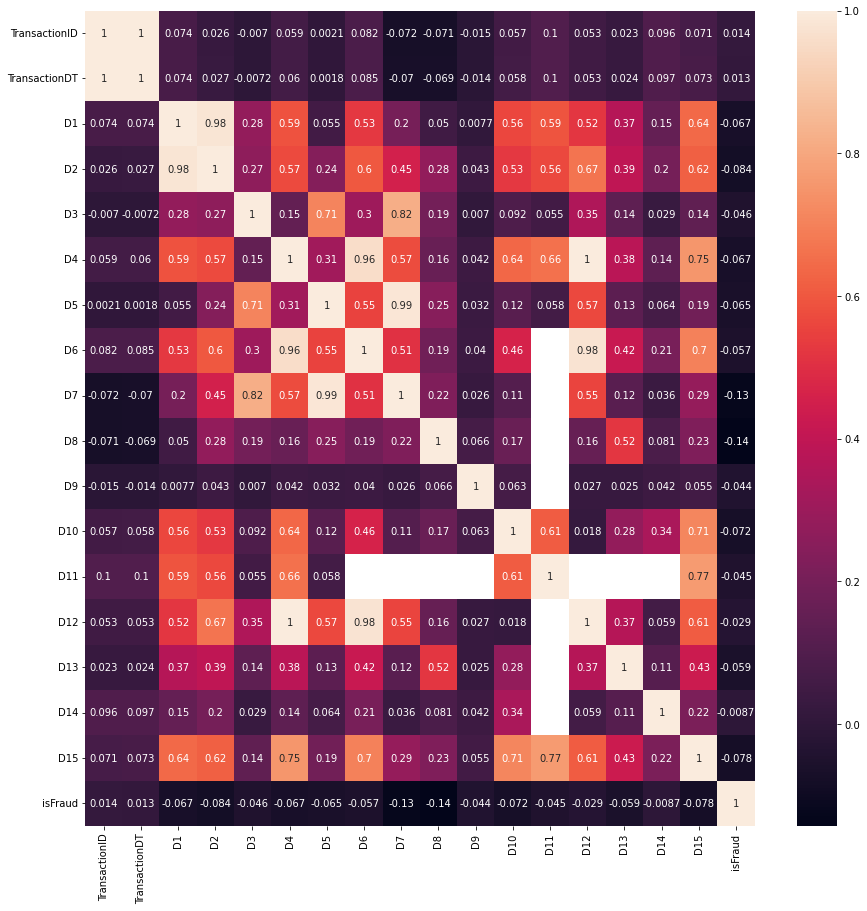

In [20]:
f = train_df2[feature_D].corr()
plt.figure(1,figsize = (15,15))
sns.heatmap(f,annot = True)
plt.show();

* D1-D2 was corr 0.98 each other, remove 1 give less corr w/ Target = D1  
* D3-D7 was corr 0.82 each other, remove 1 give less corr w/ Target = D3  
* D4-D6 was corr 0.96 each other, remove 1 give less corr w/ Target = D6  
* D5-D7 was corr 0.99 each other, remove 1 give less corr w/ Target = D5  
* D12-6 was corr 0.99 each other, D6 was gone so cut both = D6 , D12
* More cut D14 that very very less corr w/ Target = D14

In [21]:
remove_D = ['D1','D3','D5','D6','D12','D14']

In [22]:
train_df2.drop(remove_D, axis = 1, inplace = True)
test_df2.drop(remove_D, axis = 1, inplace = True)

In [23]:
train_df2.shape

(590511, 430)

In [24]:
test_df2.shape

(506691, 429)

## V representative
due to 339 feature of V so we can't filter /select feature by corr as we did previously. We will rum model then select the feature by feature important  

In [98]:
vfeatures=[]
for features in train_df2.columns:
  if features.startswith("V"):
    vfeatures.append(features)
train_v = train_df2[vfeatures]    

In [26]:
for features in vfeatures:
  train_v[features].fillna(train_v[features].median(), inplace=True)

In [27]:
V_x = train_v[:int(train_df2.shape[0]*0.70)]
V_cv = train_v[int(train_df2.shape[0]*0.70):]

train_y = train_df2["isFraud"].values[:int(train_df2.shape[0]*0.70)]
cv_y = train_df2["isFraud"].values[int(train_df2.shape[0]*0.70):]

In [28]:
clf = LGBMClassifier()
clf.fit( V_x, train_y)
print("Train AUC :",roc_auc_score(train_y, clf.predict_proba(V_x)[:,1]))
print("CV AUC :",roc_auc_score(cv_y, clf.predict_proba(V_cv)[:,1]))

Train AUC : 0.8811769329251397
CV AUC : 0.844481013543353


In [29]:
feature_V_339 = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339']

In [30]:
feature_import = clf.feature_importances_
feature_import = pd.Series(feature_import, feature_V_339).sort_values(ascending= True)

In [31]:
len(feature_import[feature_import < 5])

165

<AxesSubplot:>

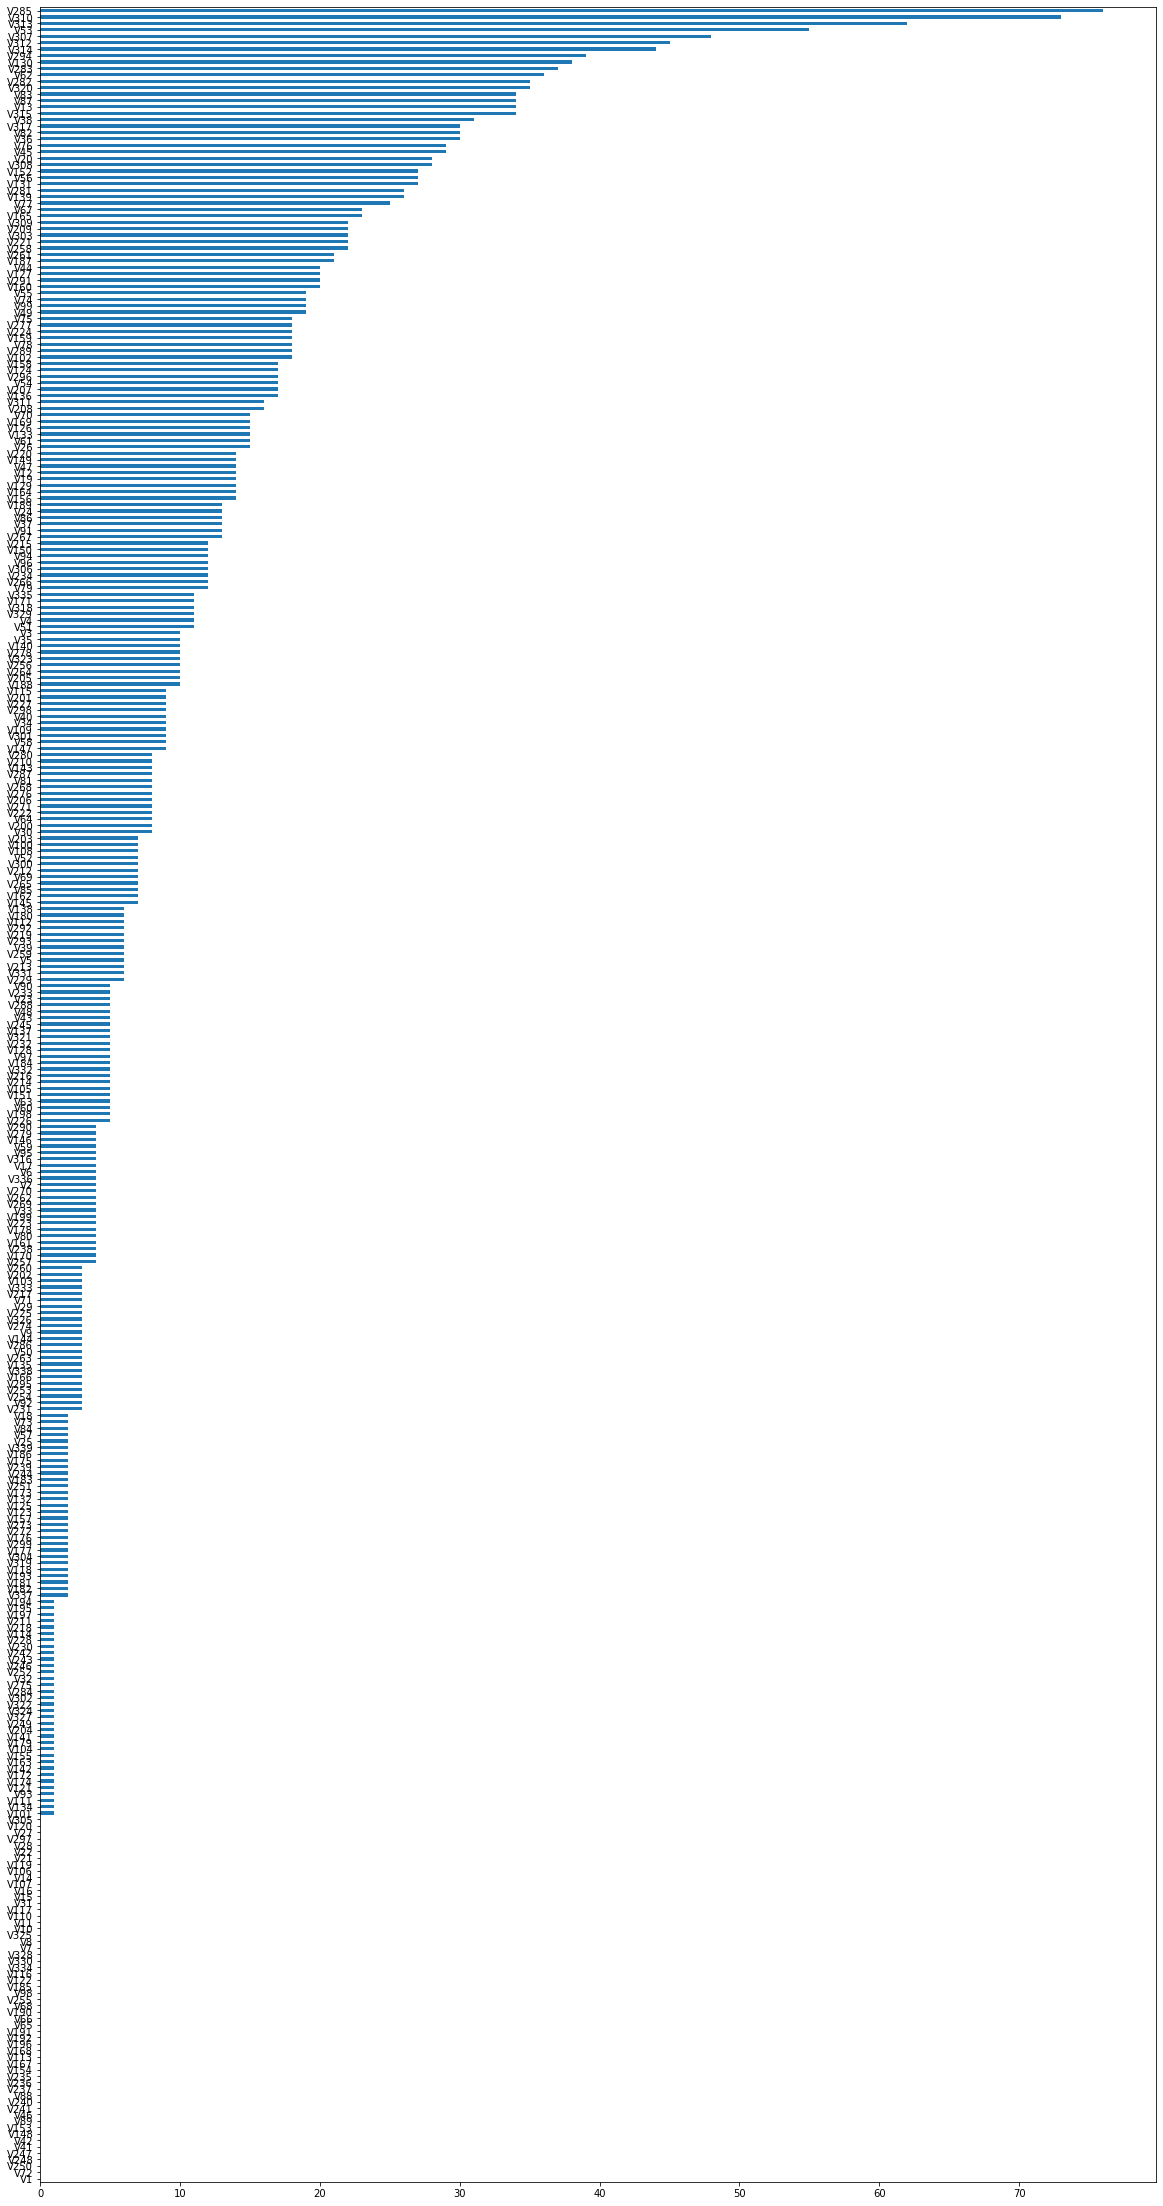

In [32]:
plt.figure(figsize = (20,40))
feature_import.plot(kind= 'barh')

In [33]:
remove_V=[]
for j,i in enumerate(clf.feature_importances_):
  if i<5:
    remove_V.append(vfeatures[j])  
len(remove_V)  

165

In [34]:
#dropping above listed V features
print(len(vfeatures))
for v in remove_V:
    vfeatures.remove(v)
print(len(vfeatures))   

339
174


In [35]:
#Removing redundant train and test features

train_df2.drop(remove_V,axis=1,inplace=True)
test_df2.drop(remove_V, axis=1,inplace=True)

In [36]:
train_df2.shape

(590511, 265)

In [37]:
test_df2.shape

(506691, 264)

## ID > 80% missing remove

In [38]:
train_df_check.apply(lambda row: row[train_df_check['index'].isin(feature_id)]).sort_values(by= 'corr offtake', ascending = False)

,index,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr offtake
432,isFraud,int8,590540,2,0,0.000000,"[0, 1]",5.061223e+00,23.616056,1.000000
128,id_17,float16,139369,105,451171,76.399736,"[nan, 166.0, 121.0, 225.0, 102.0, 148.0, 199.0...",NaN,NaN,0.150100
8,id_22,float16,5169,26,585371,99.124699,"[nan, 14.0, 41.0, 21.0, 33.0, 35.0, 19.0, 20.0...",inf,NaN,0.118409
5,id_26,float16,5163,96,585377,99.125715,"[nan, 184.0, 102.0, 159.0, 142.0, 117.0, 191.0...",inf,NaN,0.099587
24,id_32,float16,77586,5,512954,86.861855,"[nan, 32.0, 24.0, 16.0, 0.0]",NaN,NaN,0.069702
4,id_21,float16,5159,491,585381,99.126393,"[nan, 252.0, 657.0, 724.0, 228.0, 369.0, 796.0...",inf,NaN,0.063544
126,id_20,float16,139261,395,451279,76.418024,"[nan, 144.0, 500.0, 142.0, 507.0, 575.0, 600.0...",NaN,NaN,0.061597
26,id_14,float16,80044,26,510496,86.445626,"[nan, -480.0, -300.0, -360.0, -420.0, -540.0, ...",NaN,NaN,0.057324
11,id_18,float16,45113,19,545427,92.360721,"[nan, 15.0, 18.0, 13.0, 12.0, 20.0, 21.0, 14.0...",inf,NaN,0.050004
181,id_02,float32,140872,115656,449668,76.145223,"[nan, 70787.0, 98945.0, 191631.0, 221832.0, 74...",1.838789e+00,4.014414,0.049398


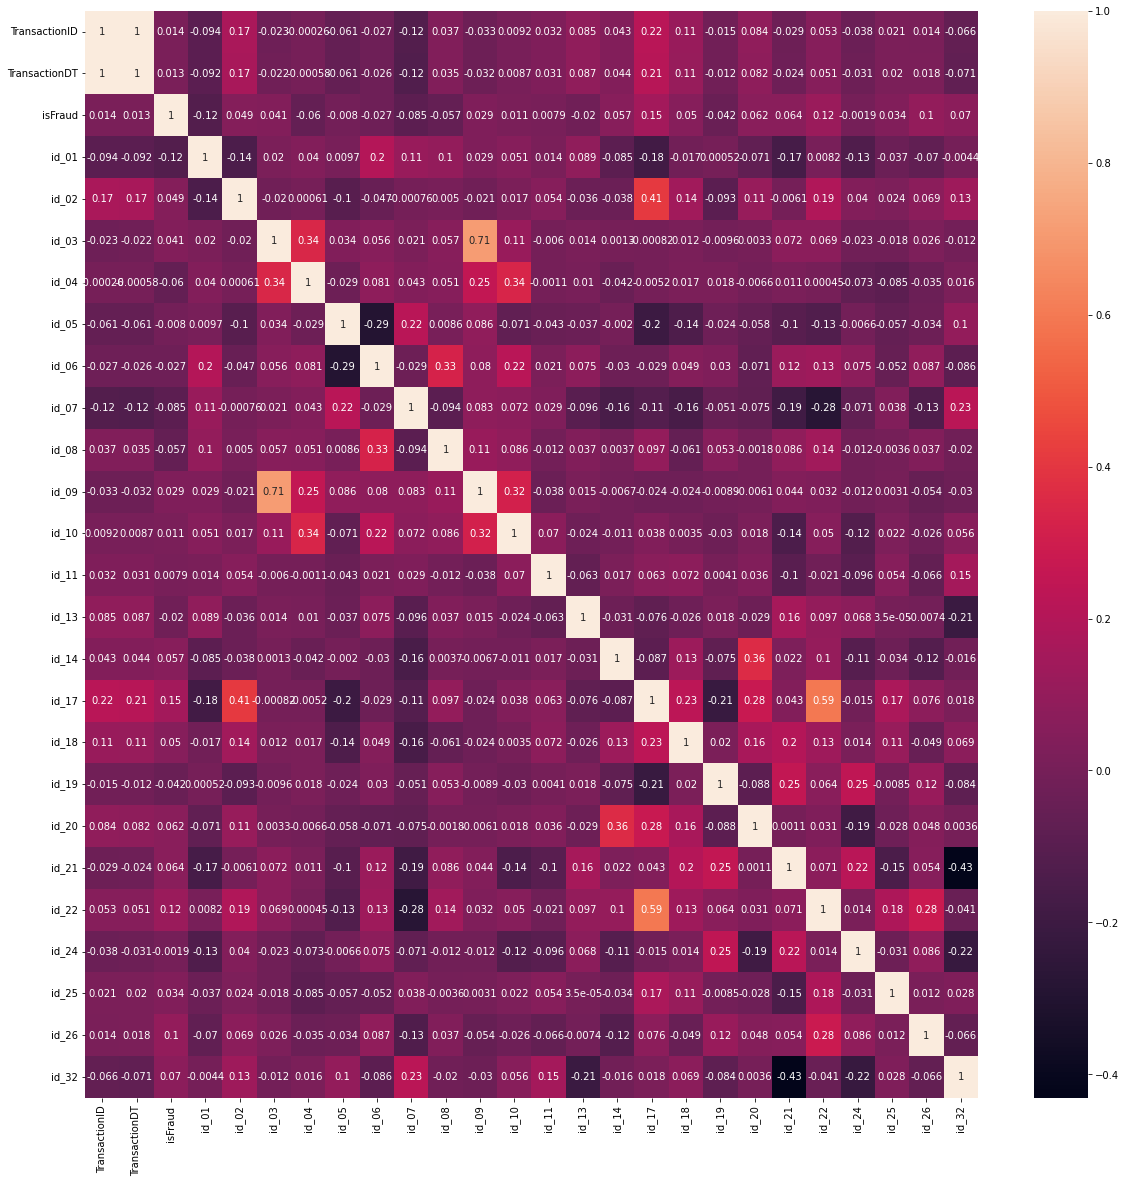

In [39]:
f = train_df2[feature_id].corr()
plt.figure(1,figsize = (20,20))
sns.heatmap(f,annot = True)
plt.show();

In [40]:
train_fea_missing_df

,missing_percent,Transaction,Prod,card,addr,dist,P_,R_,C,D,M,V,id,Dev
0,90-100%,0,0,0,0,1,0,0,0,1,0,0,10,0
1,80-89%,0,0,0,0,0,0,0,0,6,0,47,9,0
2,70-79%,0,0,0,0,0,0,1,0,2,0,112,19,2
3,60-69%,0,0,0,0,0,0,0,0,0,0,0,0,0
4,50-59%,0,0,0,0,1,0,0,0,1,4,0,0,0
5,40-49%,0,0,0,0,0,0,0,0,3,4,11,0,0
6,30-39%,0,0,0,0,0,0,0,0,0,0,0,0,0
7,20-29%,0,0,0,0,0,0,0,0,1,1,18,0,0
8,10-19%,0,0,0,2,0,1,0,0,2,0,65,0,0
9,1-9%,0,0,5,0,0,0,0,0,1,0,86,0,0


In [41]:
feature_id_38 = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

In [42]:
feature_id_check = train_df_check.apply(lambda row: row[train_df_check['index'].isin(feature_id_38)]).sort_values(by= 'corr offtake', ascending = False)
remove_id =feature_id_check[feature_id_check['corr offtake'] < 80]['index'].tolist()
len(remove_id)

23

In [43]:
remove_id

['id_17',
 'id_22',
 'id_26',
 'id_32',
 'id_21',
 'id_20',
 'id_14',
 'id_18',
 'id_02',
 'id_03',
 'id_25',
 'id_09',
 'id_10',
 'id_11',
 'id_24',
 'id_05',
 'id_13',
 'id_06',
 'id_19',
 'id_08',
 'id_04',
 'id_07',
 'id_01']

In [44]:
remove_id_test = ['id-17',
 'id-22',
 'id-26',
 'id-32',
 'id-21',
 'id-20',
 'id-14',
 'id-18',
 'id-02',
 'id-03',
 'id-25',
 'id-09',
 'id-10',
 'id-11',
 'id-24',
 'id-05',
 'id-13',
 'id-06',
 'id-19',
 'id-08',
 'id-04',
 'id-07',
 'id-01']

In [45]:
train_df2.drop(remove_id,axis=1,inplace=True)
test_df2.drop(remove_id_test, axis=1,inplace=True)

In [46]:
train_df2.shape

(590511, 242)

In [47]:
test_df2.shape

(506691, 241)

#  DATA imputation

## impute missing with Median(numerical) and Mode (categorical)

In [48]:
#inf Value check

train_df2.isin([np.inf, -np.inf]).sum().any()

False

In [49]:
test_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 241 entries, TransactionID to device_version
dtypes: float16(171), float32(35), int16(1), int32(2), object(32)
memory usage: 365.3+ MB


In [50]:
# impute numerical value by median for each feature

for i in train_df2.columns:
    if train_df2[i].dtypes == 'float16' or train_df2[i].dtypes == 'float32' or train_df2[i].dtypes == 'int16' or train_df2[i].dtypes == 'int32' :
        train_df2[i].fillna(train_df2[i].median(), inplace = True )

In [51]:
# imputation of categorical features by mode 

for i in train_df2.columns:
    if train_df2[i].dtypes == 'object':
        train_df2[i].fillna(train_df2[i].mode()[0], inplace = True)

In [52]:
train_df2.isnull().sum().any()

False

In [53]:
# impute numerical value by median for each feature

for i in test_df2.columns:
    if test_df2[i].dtypes == 'float16' or test_df2[i].dtypes == 'float32' or test_df2[i].dtypes == 'int16' or test_df2[i].dtypes == 'int32' :
        test_df2[i].fillna(test_df2[i].median(), inplace = True )

In [54]:
# imputation of categorical features by mode 

for i in test_df2.columns:
    if test_df2[i].dtypes == 'object':
        test_df2[i].fillna(test_df2[i].mode()[0], inplace = True)

In [55]:
test_df2.isnull().sum().any()

False

 ## encoding categorical 

In [56]:
# encoding categorical feature before model training using label encoder
from sklearn.preprocessing import LabelEncoder

for i in train_df2.columns:
  if train_df2[i].dtypes == "object":
    le = LabelEncoder()
    train_df2[i] = le.fit_transform(train_df2[i].astype(str).values)

In [57]:
#encoding test data using laber encoder

for i in test_df2.columns:
  if test_df2[i].dtypes == "object":
    le = LabelEncoder()
    test_df2[i] = le.fit_transform(test_df2[i].astype(str).values)

# Preprocessing

## Train Validate split

In [58]:
train_df2.shape

(590511, 242)

In [59]:
#Train test split

train_data = train_df2[:int(train_df2.shape[0]*0.70)]
cv_data = train_df2[int(train_df2.shape[0]*0.70):]

In [60]:
train_data.shape

(413357, 242)

In [61]:
cv_data.shape

(177154, 242)

In [62]:
#X-y split

x_train = train_data.drop(['isFraud'], axis = 1)
y_train = train_data['isFraud']
x_cv = cv_data.drop(['isFraud'], axis = 1)
y_cv = cv_data['isFraud']

In [63]:
#standardizing the train and cv x for logistic regression model

sc = StandardScaler()
sc_x_train = sc.fit_transform(x_train)
sc_x_cv = sc.transform(x_cv)

#Model and Evaluate

## 1.Logistic Regression

In [ ]:
#traing model with default values

clf = SGDClassifier(loss = "log")
clf.fit(sc_x_train, y_train)
y_trainpred = clf.predict_proba(sc_x_train)
y_cvpred = clf.predict_proba(sc_x_cv)

In [ ]:
print('Train AUC is :', roc_auc_score(y_train, y_trainpred[:,1]))
print('CV AUC :', roc_auc_score(y_cv, y_cvpred[:,1]))

Train AUC is : 0.8494626517341632
CV AUC : 0.8132531943204285


In [ ]:
parameters = {"alpha":[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = SGDClassifier(loss = "log", class_weight = 'balanced', penalty = "l2")
rand_clf = RandomizedSearchCV(clf, parameters, scoring = "f1", n_iter = 500, n_jobs = -1, cv = 5, random_state = 1, return_train_score = True)
rand_clf.fit(sc_x_train, y_train)

print(rand_clf.best_params_)
print(rand_clf.best_estimator_)

{'alpha': 100}
SGDClassifier(alpha=100, class_weight='balanced', loss='log')


In [ ]:
#training with best parameters now

clf_lr = SGDClassifier(loss = "log", class_weight = "balanced", alpha = rand_clf.best_params_["alpha"], penalty = "l2")
clf_lr.fit(sc_x_train, y_train)

SGDClassifier(alpha=100, class_weight='balanced', loss='log')

AUC

In [ ]:
y_trainpred = clf_lr.predict(sc_x_train)
pred_prob_train = clf_lr.predict_proba(sc_x_train)
print("Train AUC =", roc_auc_score(y_train, pred_prob_train[:,1]))

print("="*75)

y_cvpred = clf_lr.predict(sc_x_cv)
pred_prob_cv = clf_lr.predict_proba(sc_x_cv)
print("CV AUC =", roc_auc_score(y_cv, pred_prob_cv[:,1]))

Train AUC = 0.8019318048023927
CV AUC = 0.7965391724353705


F1 SCORE

In [ ]:
print("F1 score=", f1_score(y_train, y_trainpred))

F1 score= 0.21757013482855928


CONFUSION MATRIX

In [ ]:
cm_train = confusion_matrix(y_train, y_trainpred)
cm_cv  = confusion_matrix(y_cv, y_cvpred)

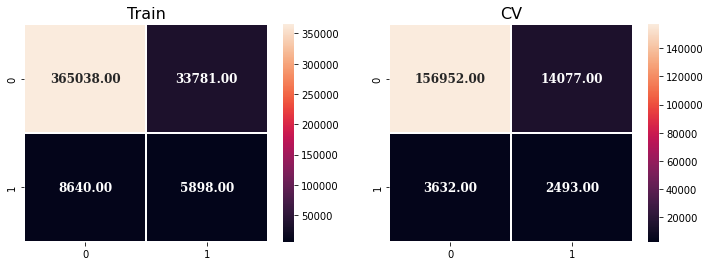

In [ ]:
plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
sns.heatmap(cm_train, annot = True, fmt = '.2f',annot_kws = {'fontsize' : 12, 'fontweight' : 'bold','fontfamily' : 'serif'},
           linewidth = 0.1)
plt.title('Train', fontsize = 16)

plt.subplot(1,2,2)
sns.heatmap(cm_cv, annot = True, fmt = '.2f',annot_kws = {'fontsize' : 12, 'fontweight' : 'bold','fontfamily' : 'serif'},
           linewidth = 0.1)
plt.title('CV', fontsize = 16);

In [ ]:
acc =  accuracy_score(y_train, y_trainpred)
acc

0.8973744245289181

In [ ]:
print( classification_report(y_train, y_trainpred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    398819
           1       0.15      0.41      0.22     14538

    accuracy                           0.90    413357
   macro avg       0.56      0.66      0.58    413357
weighted avg       0.95      0.90      0.92    413357



###**Model summary**: Model can't predict FRAUD(minority), The Accuracy was from legally(majority)


ROC AUC curve

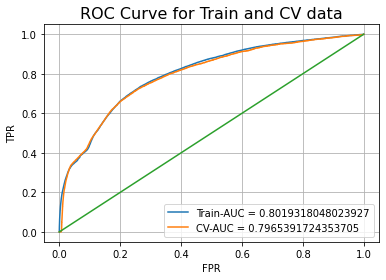

In [ ]:
# ploting ROC AUC curve

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, pred_prob_train[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, pred_prob_cv[:,1])

plt.plot(train_fpr, train_tpr, label = "Train-AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "CV-AUC = "+str(auc(test_fpr, test_tpr)))
plt.plot([0.0, 1.0], [0.0, 1.0])

plt.title("ROC Curve for Train and CV data", fontsize = 16)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()

# 2. Desicison Tree

In [96]:
# default paramter

clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
y_train_pred = clf.predict_proba(x_train)
y_cv_pred = clf.predict_proba(x_cv)

In [97]:
print('Train AUC with default parameter:', roc_auc_score(y_train, y_train_pred[:,1]))
print('CV AUC with default parameter:', roc_auc_score(y_cv, y_cv_pred[:,1]))

Train AUC with default parameter: 1.0
CV AUC with default parameter: 0.6907028966683177


In [98]:
parameter = {          
             "max_depth":[3, 5, 7, 9, 11, 13],
             "criterion": ["gini", "entropy","log_loss"],
                       
            }

In [99]:
clf = DecisionTreeClassifier(class_weight = 'balanced')
rand_clf = RandomizedSearchCV(clf, parameter, scoring = 'f1', n_jobs = -1)
rand_clf.fit(x_train, y_train)
print(rand_clf.best_params_)
print("="*60)
print(rand_clf.best_estimator_)

{'max_depth': 3, 'criterion': 'gini'}
DecisionTreeClassifier(class_weight='balanced', max_depth=3)


In [100]:
#traing with best parameters

clf_dt = DecisionTreeClassifier( max_depth = 3, criterion = 'gini', class_weight = 'balanced')
clf_dt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3)

In [102]:
y_trainpred = clf_dt.predict(x_train)
pred_prob_train = clf_dt.predict_proba(x_train)
print("Train AUC =", roc_auc_score(y_train, pred_prob_train[:,1]))

print("="*75)

y_cvpred = clf_dt.predict(x_cv)
pred_prob_cv = clf_dt.predict_proba(x_cv)
print("CV AUC =", roc_auc_score(y_cv, pred_prob_cv[:,1]))

Train AUC = 0.7636796162647103
CV AUC = 0.7584202492929651


In [103]:
f1_score(y_train, y_trainpred)

0.22277125296659162

In [104]:
cm_train = confusion_matrix(y_train, y_trainpred)
cm_cv  = confusion_matrix(y_cv, y_cvpred)

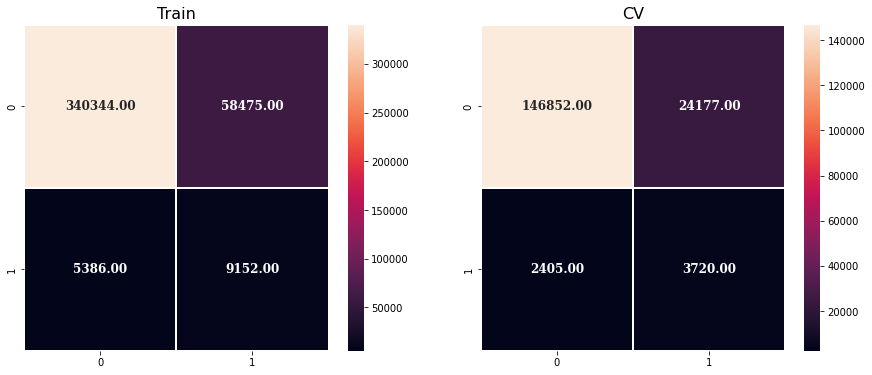

In [106]:
plt.figure(figsize = (15, 6))
plt.subplot(1,2,1)
sns.heatmap(cm_train, annot = True, fmt = '.2f',annot_kws = {'fontsize' : 12, 'fontweight' : 'bold','fontfamily' : 'serif'},
           linewidth = 0.1)
plt.title('Train', fontsize = 16)

plt.subplot(1,2,2)
sns.heatmap(cm_cv, annot = True, fmt = '.2f',annot_kws = {'fontsize' : 12, 'fontweight' : 'bold','fontfamily' : 'serif'},
           linewidth = 0.1)
plt.title('CV', fontsize = 16);

In [107]:
acc =  accuracy_score(y_train, y_trainpred)
acc

0.8455064266481516

In [108]:
print( classification_report(y_train, y_trainpred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91    398819
           1       0.14      0.63      0.22     14538

    accuracy                           0.85    413357
   macro avg       0.56      0.74      0.57    413357
weighted avg       0.95      0.85      0.89    413357



### **Model summary**: Model more recall FRAUD

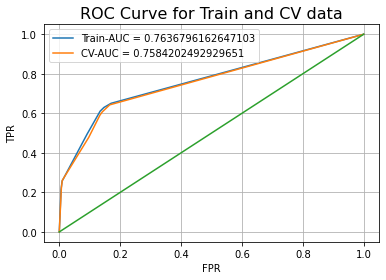

In [109]:
# ploting ROC AUC curve

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, pred_prob_train[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, pred_prob_cv[:,1])

plt.plot(train_fpr, train_tpr, label = "Train-AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "CV-AUC = "+str(auc(test_fpr, test_tpr)))
plt.plot([0.0, 1.0], [0.0, 1.0])

plt.title("ROC Curve for Train and CV data", fontsize = 16)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()

##SMOTE >> solve imbalance case by oversampling

In [64]:
from imblearn.over_sampling import SMOTE

In [65]:
# Applying SMOTE to deal with the class imbalance by oversampling
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(sc_x_train, y_train)
print(X_train_smote.shape, y_train_smote.shape)

pd.value_counts(y_train_smote)

(797638, 241) (797638,)


0    398819
1    398819
Name: isFraud, dtype: int64

# 3. Logistic Regression After SMOTE

In [66]:
#traing model with default values

clf = SGDClassifier(loss = "log")
clf.fit(X_train_smote, y_train_smote)
y_trainpred = clf.predict_proba(X_train_smote)
y_cvpred = clf.predict_proba(sc_x_cv)

In [68]:
print('Train AUC is :', roc_auc_score(y_train_smote, y_trainpred[:,1]))
print('CV AUC :', roc_auc_score(y_cv, y_cvpred[:,1]))

Train AUC is : 0.8654453915591582
CV AUC : 0.8257574902263265


In [69]:
parameters = {"alpha":[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = SGDClassifier(loss = "log", class_weight = 'balanced', penalty = "l2")
rand_clf = RandomizedSearchCV(clf, parameters, scoring = "f1", n_iter = 500, n_jobs = -1, cv = 5, random_state = 1, return_train_score = True)
rand_clf.fit(X_train_smote, y_train_smote)

print(rand_clf.best_params_)
print(rand_clf.best_estimator_)

{'alpha': 0.01}
SGDClassifier(alpha=0.01, class_weight='balanced', loss='log')


In [70]:
#training with best parameters now

clf_lr = SGDClassifier(loss = "log", class_weight = "balanced", alpha = rand_clf.best_params_["alpha"], penalty = "l2")
clf_lr.fit(X_train_smote, y_train_smote)

SGDClassifier(alpha=0.01, class_weight='balanced', loss='log')

In [71]:
y_trainpred = clf_lr.predict(X_train_smote)
pred_prob_train = clf_lr.predict_proba(X_train_smote)
print("Train AUC =", roc_auc_score(y_train_smote, pred_prob_train[:,1]))

print("="*75)

y_cvpred = clf_lr.predict(sc_x_cv)
pred_prob_cv = clf_lr.predict_proba(sc_x_cv)
print("CV AUC =", roc_auc_score(y_cv, pred_prob_cv[:,1]))

Train AUC = 0.8609638321992895
CV AUC = 0.8288526292414189


In [72]:
print("F1 score=", f1_score(y_train_smote, y_trainpred))

F1 score= 0.77270356290909


In [73]:
cm_train = confusion_matrix(y_train_smote, y_trainpred)
cm_cv  = confusion_matrix(y_cv, y_cvpred)

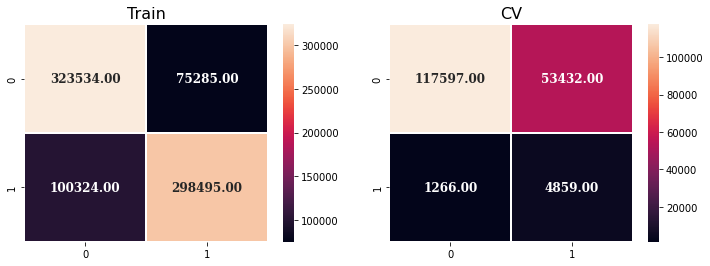

In [74]:
plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
sns.heatmap(cm_train, annot = True, fmt = '.2f',annot_kws = {'fontsize' : 12, 'fontweight' : 'bold','fontfamily' : 'serif'},
           linewidth = 0.1)
plt.title('Train', fontsize = 16)

plt.subplot(1,2,2)
sns.heatmap(cm_cv, annot = True, fmt = '.2f',annot_kws = {'fontsize' : 12, 'fontweight' : 'bold','fontfamily' : 'serif'},
           linewidth = 0.1)
plt.title('CV', fontsize = 16);

In [75]:
acc =  accuracy_score(y_train_smote, y_trainpred)
acc

0.7798387238321143

In [76]:
print( classification_report(y_train_smote, y_trainpred))

              precision    recall  f1-score   support

           0       0.76      0.81      0.79    398819
           1       0.80      0.75      0.77    398819

    accuracy                           0.78    797638
   macro avg       0.78      0.78      0.78    797638
weighted avg       0.78      0.78      0.78    797638



### **Model summary** improve to predict FRAUD significantly after data balance now

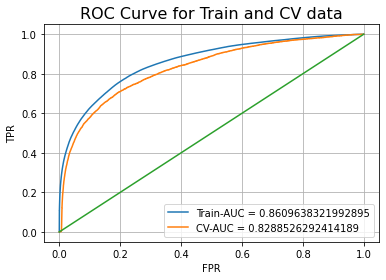

In [77]:
# ploting ROC AUC curve

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_smote, pred_prob_train[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, pred_prob_cv[:,1])

plt.plot(train_fpr, train_tpr, label = "Train-AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "CV-AUC = "+str(auc(test_fpr, test_tpr)))
plt.plot([0.0, 1.0], [0.0, 1.0])

plt.title("ROC Curve for Train and CV data", fontsize = 16)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()

#4. DecisionTree After SMOTE

In [78]:
# Applying SMOTE to deal with the class imbalance by oversampling
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
print(X_train_smote.shape, y_train_smote.shape)

pd.value_counts(y_train_smote)

(797638, 241) (797638,)


0    398819
1    398819
Name: isFraud, dtype: int64

In [79]:
# default paramter

clf = DecisionTreeClassifier()
clf.fit(X_train_smote, y_train_smote)
y_train_pred = clf.predict_proba(X_train_smote)
y_cv_pred = clf.predict_proba(x_cv)

In [80]:
print('Train AUC with default parameter:', roc_auc_score(y_train_smote, y_train_pred[:,1]))
print('CV AUC with default parameter:', roc_auc_score(y_cv, y_cv_pred[:,1]))

Train AUC with default parameter: 1.0
CV AUC with default parameter: 0.6817640077986534


In [81]:
parameter = {          
             "max_depth":[3, 5, 7, 9, 11, 13],
             "criterion": ["gini", "entropy","log_loss"],
                       
            }

In [82]:
clf = DecisionTreeClassifier(class_weight = 'balanced')
rand_clf = RandomizedSearchCV(clf, parameter, scoring = 'f1', n_jobs = -1)
rand_clf.fit(X_train_smote, y_train_smote)
print(rand_clf.best_params_)
print("="*60)
print(rand_clf.best_estimator_)

{'max_depth': 5, 'criterion': 'entropy'}
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5)


In [83]:
#traing with best parameters

clf_dt = DecisionTreeClassifier( max_depth = 5, criterion = 'entropy', class_weight = 'balanced')
clf_dt.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5)

In [84]:
y_trainpred = clf_dt.predict(X_train_smote)
pred_prob_train = clf_dt.predict_proba(X_train_smote)
print("Train AUC =", roc_auc_score(y_train_smote, pred_prob_train[:,1]))

print("="*75)

y_cvpred = clf_dt.predict(x_cv)
pred_prob_cv = clf_dt.predict_proba(x_cv)
print("CV AUC =", roc_auc_score(y_cv, pred_prob_cv[:,1]))

Train AUC = 0.942515499758191
CV AUC = 0.7691362417234169


In [86]:
f1_score(y_train_smote, y_trainpred)

0.8847807896138146

In [87]:
cm_train = confusion_matrix(y_train_smote, y_trainpred)
cm_cv  = confusion_matrix(y_cv, y_cvpred)

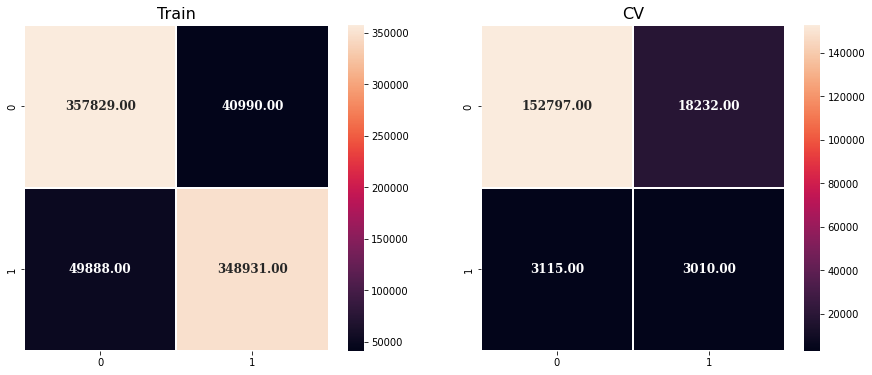

In [88]:
plt.figure(figsize = (15, 6))
plt.subplot(1,2,1)
sns.heatmap(cm_train, annot = True, fmt = '.2f',annot_kws = {'fontsize' : 12, 'fontweight' : 'bold','fontfamily' : 'serif'},
           linewidth = 0.1)
plt.title('Train', fontsize = 16)

plt.subplot(1,2,2)
sns.heatmap(cm_cv, annot = True, fmt = '.2f',annot_kws = {'fontsize' : 12, 'fontweight' : 'bold','fontfamily' : 'serif'},
           linewidth = 0.1)
plt.title('CV', fontsize = 16);

In [89]:
acc =  accuracy_score(y_train_smote, y_trainpred)
acc

0.886066110190337

In [90]:
print( classification_report(y_train_smote, y_trainpred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89    398819
           1       0.89      0.87      0.88    398819

    accuracy                           0.89    797638
   macro avg       0.89      0.89      0.89    797638
weighted avg       0.89      0.89      0.89    797638



### **Model Summary**: Tree classifier usual accurate then Logistic with their complexity inside (more complex in Random forest untill alll bagging method
* **it definitely see more improve to predict FRAUD**

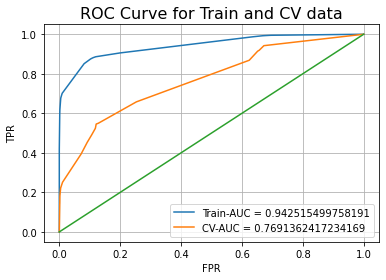

In [91]:
# ploting ROC AUC curve

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_smote, pred_prob_train[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, pred_prob_cv[:,1])

plt.plot(train_fpr, train_tpr, label = "Train-AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "CV-AUC = "+str(auc(test_fpr, test_tpr)))
plt.plot([0.0, 1.0], [0.0, 1.0])

plt.title("ROC Curve for Train and CV data", fontsize = 16)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()

# Feature_importances

In [94]:
features_columns = x_train.columns.tolist()

In [95]:
feature_import = clf_dt.feature_importances_
feature_import = pd.Series(feature_import, features_columns).sort_values(ascending= True)

<AxesSubplot:>

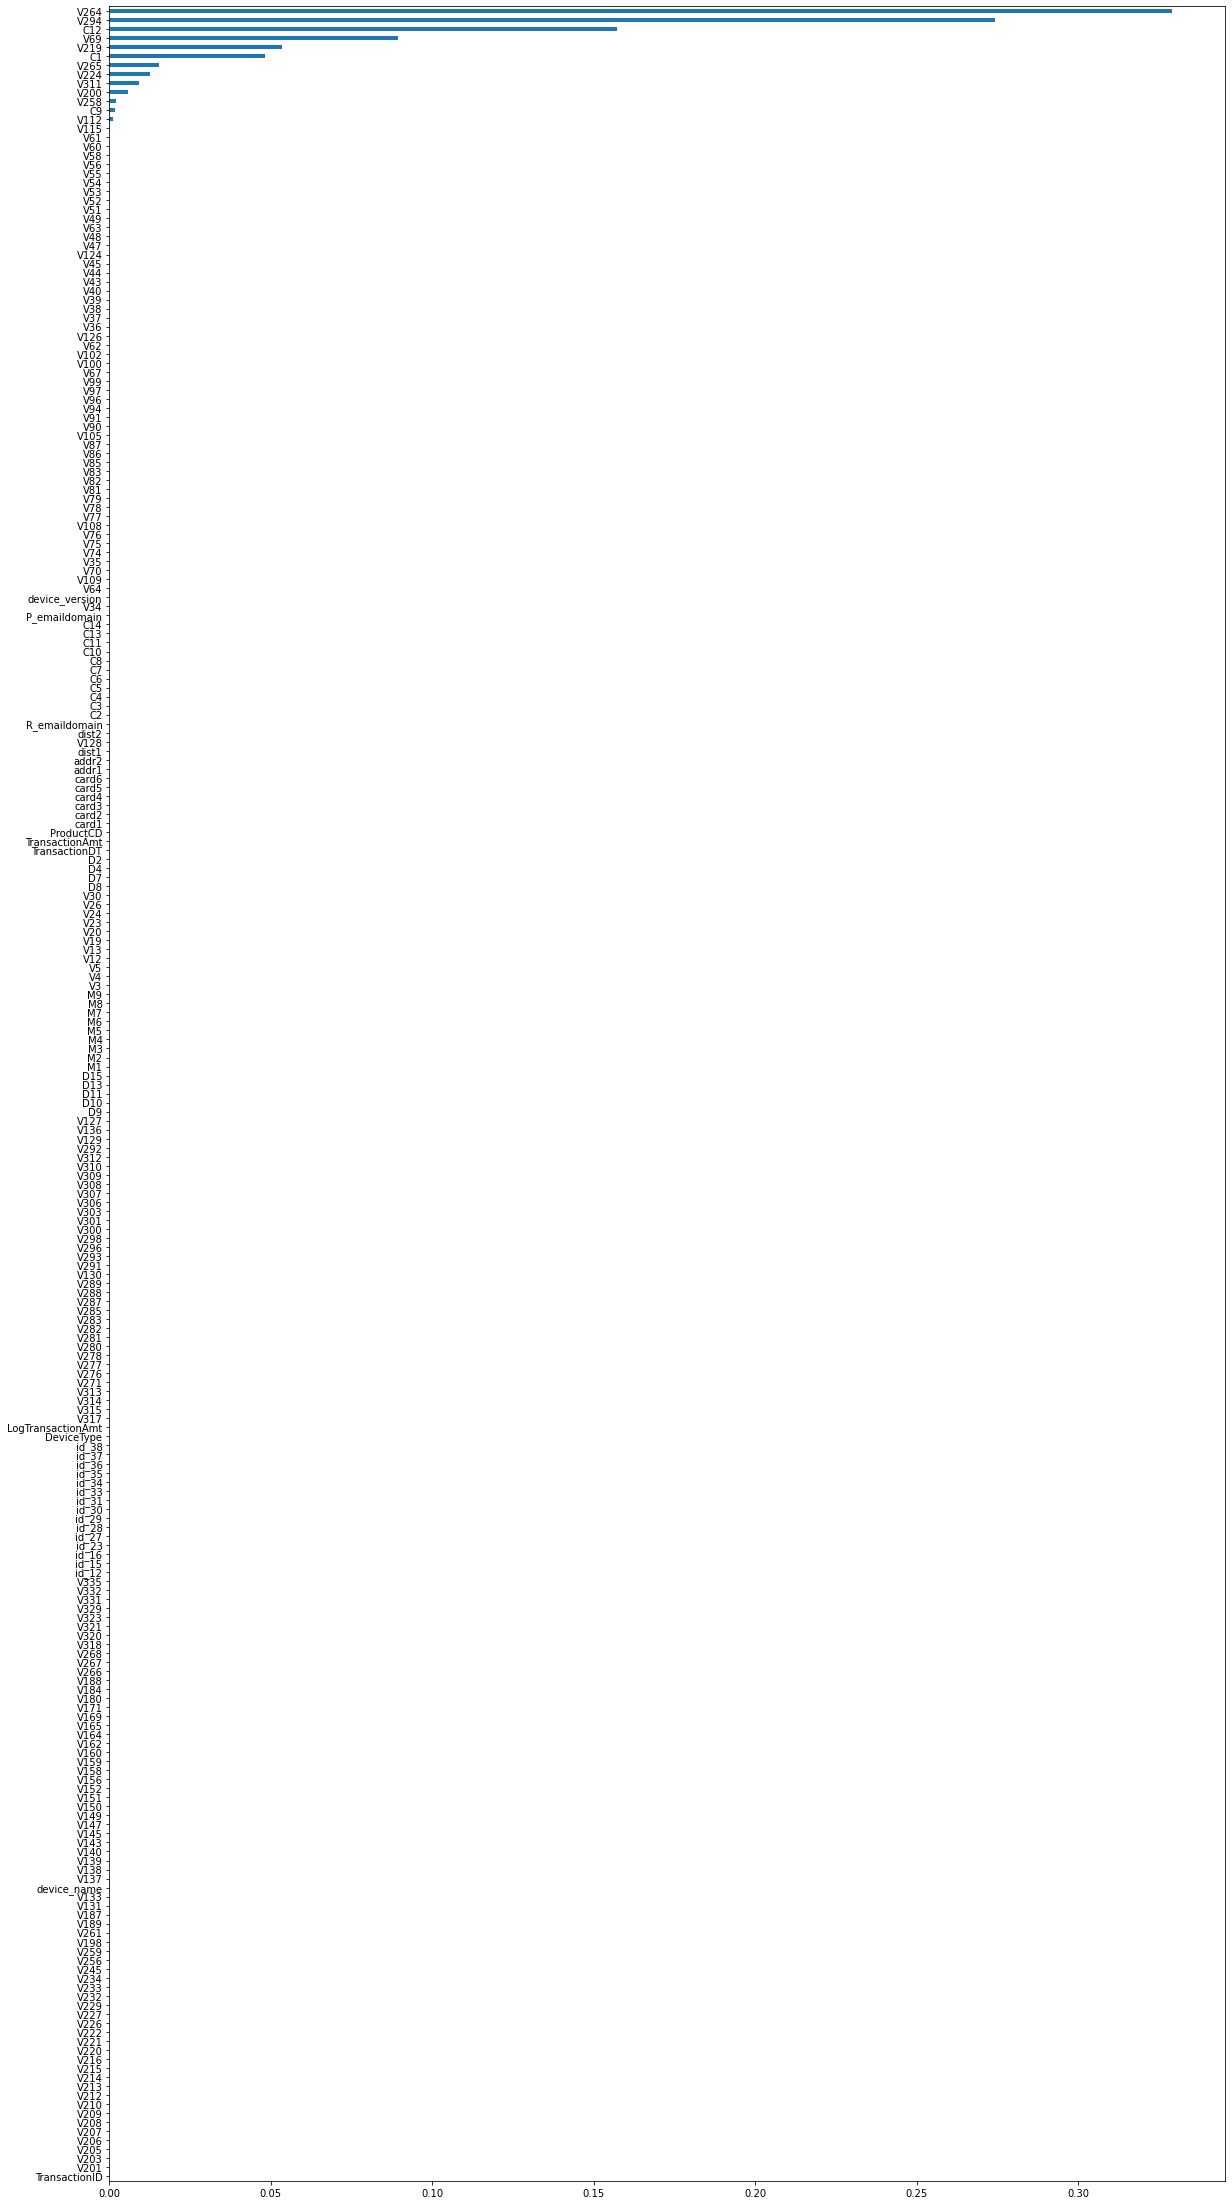

In [97]:
plt.figure(figsize = (20,40))
feature_import.plot(kind= 'barh')

from hundred unit of feature, it were around 10 feature were most important to detect FRAUD

## Testset

In [99]:
test_df2.shape

(506691, 241)

In [101]:
#X-y split

x_test = test_df2

In [102]:
#standardizing the train and cv x for logistic regression model

sc = StandardScaler()
sc_x_test = sc.fit_transform(x_test)

In [103]:
y_trainpred = clf_dt.predict(sc_x_test)
pred_prob_train = clf_dt.predict_proba(sc_x_test)

In [104]:
y_trainpred

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [105]:
len(y_trainpred)

506691

In [106]:
test_df2.shape

(506691, 241)

In [110]:
test_df2['TransactionID'].head()

0    3663549
1    3663550
2    3663551
3    3663552
4    3663553
Name: TransactionID, dtype: int32

In [118]:
Fraud_Submit = pd.DataFrame(list(zip(test_df2['TransactionID'].tolist(), y_trainpred.tolist())),
                             columns =['TransactionID', 'isFraud'])

In [119]:
Fraud_Submit.head()

,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0


In [121]:
Fraud_Submit.to_csv('/content/drive/MyDrive/fraud/Fraud_Submit.csv')